# BLE Proximity Experiment - KNN Regressor
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [56]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,0-1 meters,0.0
1,0.0,0.0,-46,-46.500000,0-1 meters,0.0
2,0.0,0.0,-46,-46.333333,0-1 meters,0.0
3,0.0,0.0,-47,-46.500000,0-1 meters,0.0
4,0.0,0.0,-47,-46.600000,0-1 meters,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,3-4 meters,3.5
12471,0.0,3.5,-87,-84.684211,3-4 meters,3.5
12472,0.0,3.5,-87,-84.800000,3-4 meters,3.5
12473,0.0,3.5,-87,-84.904762,3-4 meters,3.5


(12475, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,3-4 meters,3.5
411,0.0,3.5,-88,-84.500000,3-4 meters,3.5
412,0.0,3.5,-84,-84.428571,3-4 meters,3.5
413,0.0,3.5,-83,-84.250000,3-4 meters,3.5


(415, 6)

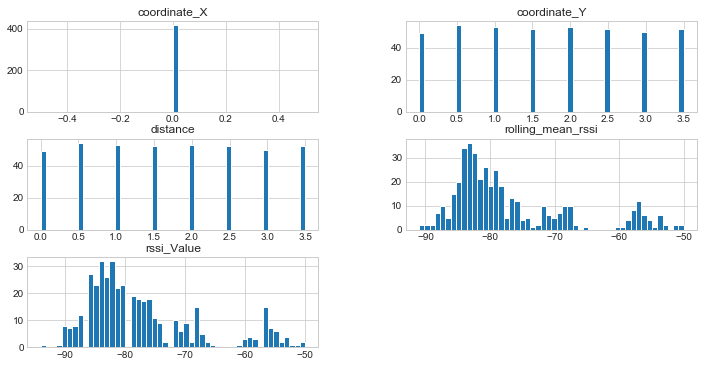

In [5]:
test_dataset = load_file('../../distance_proximity_experiments-checkpoint.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (My Device)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,0-1 meters,0.0
1,0.0,0.0,-44,-44.000000,0-1 meters,0.0
2,0.0,0.0,-44,-44.000000,0-1 meters,0.0
3,0.0,0.0,-44,-44.000000,0-1 meters,0.0
4,0.0,0.0,-45,-44.200000,0-1 meters,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,3-4 meters,3.5
2280,0.0,3.5,-85,-84.000000,3-4 meters,3.5
2281,0.0,3.5,-85,-84.050000,3-4 meters,3.5
2282,0.0,3.5,-92,-84.428571,3-4 meters,3.5


(2284, 6)

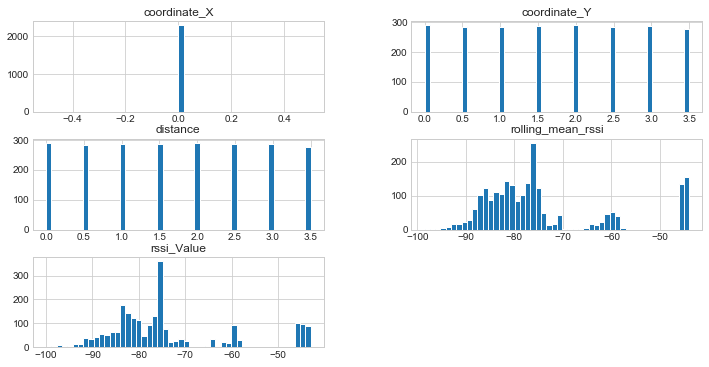

In [6]:
test_dataset_my_device = load_file('../../dataset_test.csv')
positions = test_dataset_my_device['coordinate_Y']
test_dataset_my_device['distance'] = positions
replace_features_nan(test_dataset_my_device)
display(test_dataset_my_device)
display(test_dataset_my_device.shape)
test_dataset_my_device.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [7]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12475 entries, 0 to 12474
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       12475 non-null  float64
 1   coordinate_Y       12475 non-null  float64
 2   rssi_Value         12475 non-null  int64  
 3   rolling_mean_rssi  12475 non-null  float64
 4   zone               12475 non-null  object 
 5   distance           12475 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 584.9+ KB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [8]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,12475.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0
coordinate_Y,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5
rssi_Value,12475.0,-73.416754,12.929039,-102.0,-82.0,-76.000000,-64.00,-45.0
rolling_mean_rssi,12475.0,-73.454044,12.766312,-98.5,-82.2,-76.285714,-63.75,-46.0
distance,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5


### % of Missing Values

In [9]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [10]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

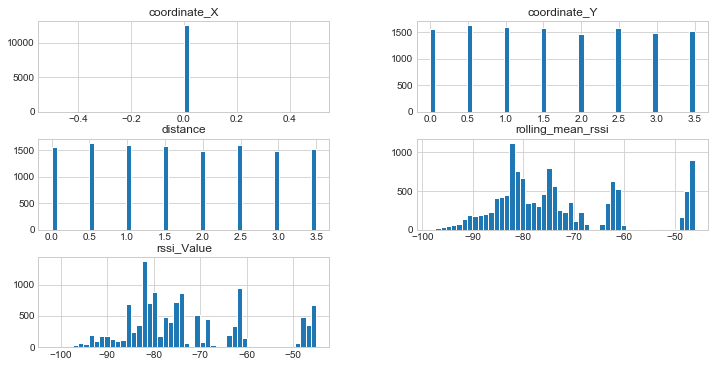

In [11]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Distance
Graphical display of the distances beacon/smartphone scanned in the experiment

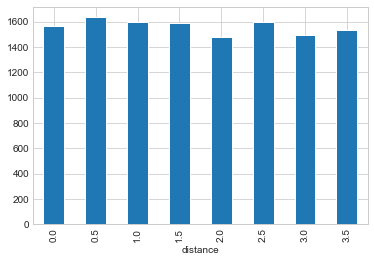

In [14]:
reference_points = dataset.groupby(['distance'])
reference_points.size().plot(kind="bar")

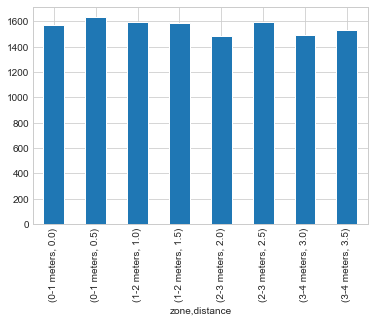

In [15]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

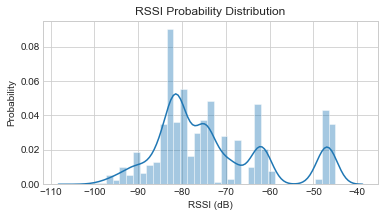

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

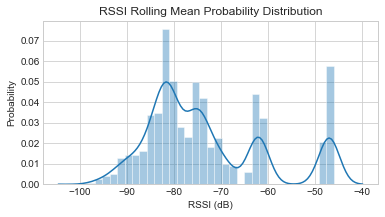

In [17]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

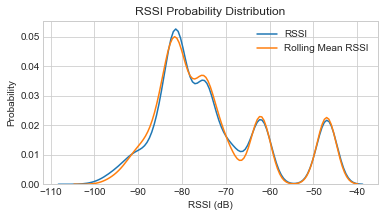

In [18]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [19]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.864615,-0.873980,1.000000
rssi_Value,NaN,-0.864615,1.000000,0.981441,-0.864615
rolling_mean_rssi,NaN,-0.873980,0.981441,1.000000,-0.873980
distance,NaN,1.000000,-0.864615,-0.873980,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.864615
rolling_mean_rssi   -0.873980
coordinate_X              NaN
Name: distance, dtype: float64

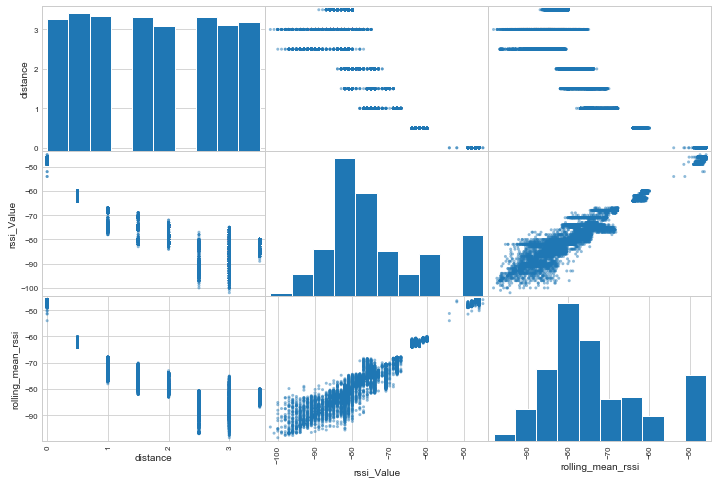

In [20]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [21]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [22]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_my_device,'rssi_Value')
compute_data_cleaning(test_dataset_my_device,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [29]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [30]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
12470,3-4 meters
12471,3-4 meters
12472,3-4 meters
12473,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
410,3-4 meters
411,3-4 meters
412,3-4 meters
413,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
categorical_zone = test_dataset_my_device[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_my_device['labels'] = test_changed

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
2279,3-4 meters
2280,3-4 meters
2281,3-4 meters
2282,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Initialize Training Data
Training Data intialization for predictions purposes

In [69]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)
default_groups = dataset['labels'].values.reshape(-1,1)

(12475, 1)

(12475, 1)

(12475, 2)

In [70]:
train_Y = pd.DataFrame(dataset['distance']).values.reshape(-1,1)
display(train_Y.shape)

(12475, 1)

In [71]:
data_plot_means = dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-46.968092,-47.021513
0.5,-62.033680,-62.095919
1.0,-72.603762,-72.674899
1.5,-75.288328,-75.305907
2.0,-77.997297,-78.097067
2.5,-85.411802,-85.401609
3.0,-85.788874,-85.766588
3.5,-82.578431,-82.604804


### Plot Training Data
Graphical Display of the observations in the dataset

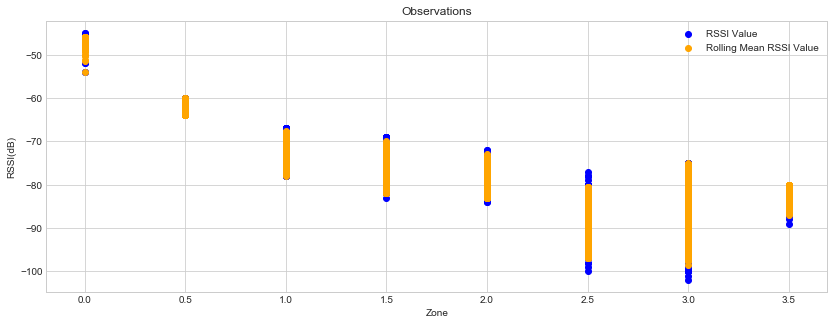

In [72]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [73]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(415, 1)

(415, 1)

(415, 2)

In [74]:
test_Y = pd.DataFrame(test_dataset['distance']).values.reshape(-1,1)
display(test_Y.shape)

(415, 1)

In [75]:
data_plot_means = test_dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-56.142857,-55.970408
0.5,-69.648148,-69.613316
1.0,-80.830189,-81.069969
1.5,-78.211538,-78.589148
2.0,-81.660377,-81.347469
2.5,-82.692308,-82.339034
3.0,-85.580000,-85.826857
3.5,-82.903846,-82.107601


In [76]:
test_X_rssi_my_device = pd.DataFrame(test_dataset_my_device['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_my_device.shape)
test_X_rolling_mean_my_device = pd.DataFrame(test_dataset_my_device['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_my_device.shape)
test_combination_features_X_my_device = test_dataset_my_device[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_my_device.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [77]:
test_Y_my_device = pd.DataFrame(test_dataset_my_device['distance']).values.reshape(-1,1)
display(test_Y_my_device.shape)

(2284, 1)

In [78]:
data_plot_means = test_dataset_my_device.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-45.031142,-45.084670
0.5,-65.678445,-65.650259
1.0,-81.529825,-82.371972
1.5,-76.397213,-76.567491
2.0,-77.820069,-77.773290
2.5,-77.922807,-78.193963
3.0,-84.552083,-84.450405
3.5,-86.147482,-86.074210


### Plot Test Data

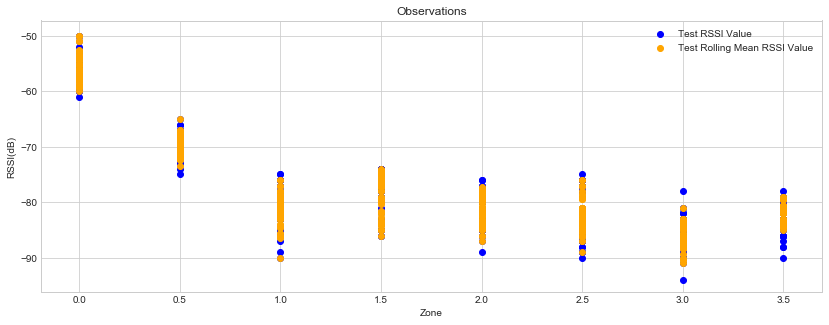

In [79]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['distance'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['distance'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

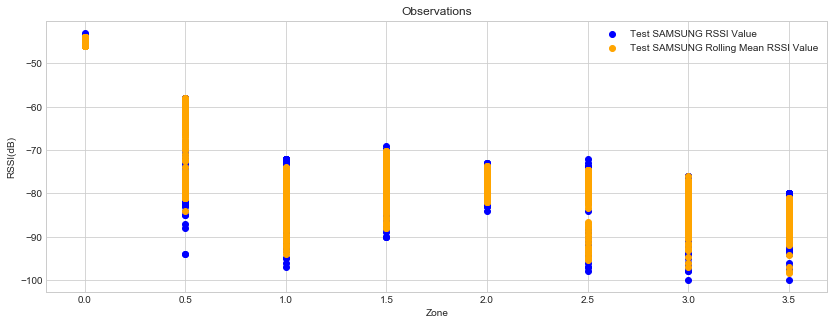

In [80]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_my_device['distance'],test_dataset_my_device['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_my_device['distance'],test_dataset_my_device['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Hyperparameters for tunning

In [81]:
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
weights = ["uniform","distance"]
knn_basic = KNeighborsRegressor()
print("DEFAULT HYPERPARAMETERS")
default_params = knn_basic.get_params()
display(pd.DataFrame(default_params,index=[1])) 

DEFAULT HYPERPARAMETERS


,algorithm,leaf_size,metric,metric_params,n_jobs,n_neighbors,p,weights
1,auto,30,minkowski,None,None,5,2,uniform


### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [82]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.10297967, 0.89702033])

rolling_mean_rssi    0.89702
rssi_Value           0.10298
dtype: float64

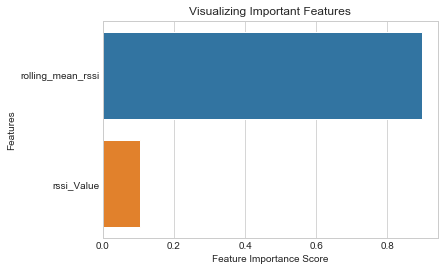

In [84]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestRegressor()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - KNN Regression Mode

In [85]:
def compute_KNN_with_Regressor(flag=0,trainX_data = None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                cross_validation = None,n_neighbors=5,weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                metric_params=None, n_jobs=-1):
    knn_regression_estimator = KNeighborsRegressor(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_regression_estimator)
    else:
        main_estimator = knn_regression_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    statistical_array = list()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
    error = pd.DataFrame(observed_errors, columns=["error"])
    result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
    return structure_data(result,coefficient_determination)


#### Check Training model with no cross validation
Use KNN Regressor to check the results on the training data alone

,Actual,Predicted
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
12470,3.5,3.4
12471,3.5,3.4
12472,3.5,3.4
12473,3.5,3.4


,Actual,Predicted
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
12470,3.5,3.3
12471,3.5,3.2
12472,3.5,3.1
12473,3.5,3.1


,Actual,Predicted
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
12470,3.5,3.0
12471,3.5,3.0
12472,3.5,3.1
12473,3.5,3.2


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
2,0.182621,0.120574,0.347238,0.347180,0.0,0.0,0.0,0.5,-2.0,1.7,0.907982,Both
1,0.266381,0.166088,0.407539,0.407542,-0.2,0.0,0.1,0.6,-1.9,1.9,0.873247,Rolling Mean RSSI
0,0.313964,0.253413,0.503402,0.495757,-0.2,0.0,0.0,0.7,-2.0,1.4,0.806604,RSSI Only


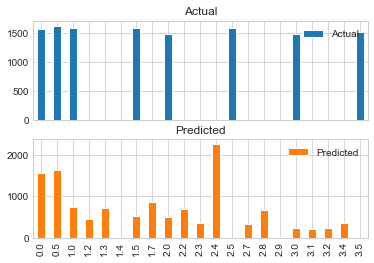

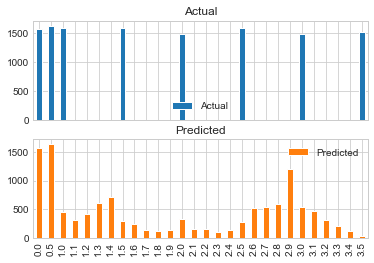

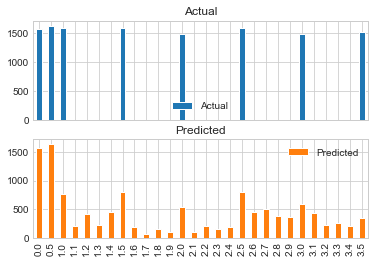

In [86]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    result = compute_KNN_with_Regressor(flag=1,trainX_data=trainX_data,trainY_data=train_Y,
                                   testX_data=trainX_data,testY_data=train_Y,
                                   scaler=StandardScaler())
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

#### Experiment - KNN with StratifiedKFold
Experiment using cross validation approach of StratifiedKFold

In [92]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
for feature in types:
    
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for cv in cross_validation_list:
        skf = StratifiedKFold(n_splits=cv)
        splited = skf.split(trainX_data,default_groups)
        result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
        result.append(cv)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds,type
11,0.258012,0.192084,0.438274,0.438026,-0.1,0.0,0.0,0.7,-2.0,2.0,0.853408,5,Both
9,0.280240,0.219392,0.468393,0.467341,-0.1,0.0,0.0,0.6,-2.0,2.0,0.832567,3,Both
10,0.280962,0.215509,0.464230,0.464205,-0.1,0.0,0.0,0.7,-2.0,2.0,0.835531,4,Both
1,0.322950,0.240681,0.490593,0.488351,-0.3,0.0,0.1,0.7,-1.9,1.4,0.816320,3,RSSI Only
7,0.327519,0.234344,0.484091,0.483962,-0.3,0.0,0.1,0.8,-1.9,2.0,0.821157,5,Rolling Mean RSSI
6,0.335952,0.244901,0.494875,0.494413,-0.3,0.0,0.1,0.8,-1.9,2.0,0.813100,4,Rolling Mean RSSI
5,0.336008,0.244705,0.494676,0.494245,-0.3,0.0,0.1,0.7,-1.9,2.0,0.813250,3,Rolling Mean RSSI
3,0.340641,0.297038,0.545012,0.542789,-0.1,0.0,0.0,0.9,-2.0,1.6,0.773311,5,RSSI Only
2,0.343351,0.262293,0.512146,0.510591,-0.2,0.0,0.1,0.7,-1.6,1.4,0.799827,4,RSSI Only
0,0.445916,0.307505,0.554531,0.554152,-0.5,0.0,0.5,0.5,-1.6,1.4,0.765323,2,RSSI Only


Number of Folds:  5


#### Experiment - KNN with HoldOut
Experiment using cross validation approach of HoldOut (Train test split)

In [95]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = size, random_state = 42,stratify=default_groups)
        result = compute_KNN_with_Regressor(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        result.append(size)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size,type
21,0.208116,0.142824,0.377920,0.377951,-0.1,0.0,0.0,0.600,-2.0,2.0,0.889942,0.4,Both
20,0.209431,0.142696,0.377751,0.377784,-0.1,0.0,0.0,0.600,-2.0,2.0,0.890388,0.3,Both
24,0.210569,0.140148,0.374363,0.374358,0.0,0.0,0.0,0.700,-2.0,2.0,0.892598,0.7,Both
19,0.211543,0.144513,0.380149,0.380197,0.0,0.0,0.0,0.600,-2.0,2.0,0.888360,0.2,Both
22,0.214508,0.147895,0.384571,0.384450,0.0,0.0,0.0,0.700,-2.0,2.0,0.886134,0.5,Both
23,0.214536,0.143631,0.378987,0.378852,0.0,0.0,0.0,0.700,-1.9,2.0,0.889646,0.6,Both
25,0.216894,0.143834,0.379254,0.379269,-0.1,0.0,0.0,0.600,-2.0,2.0,0.889970,0.8,Both
18,0.218109,0.149888,0.387153,0.387127,0.0,0.0,0.0,0.600,-1.5,2.0,0.882799,0.1,Both
26,0.218561,0.148035,0.384754,0.384435,-0.1,0.0,0.0,0.500,-2.0,2.0,0.886587,0.9,Both
15,0.286419,0.192354,0.438582,0.438508,-0.2,0.0,0.1,0.700,-1.9,2.0,0.852589,0.7,Rolling Mean RSSI


#### Experiment - KNN with Leave One Group Out
Experiment using cross validation approach of Leave One Group Out

In [102]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
    result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
1,0.810084,0.783473,0.885140,0.847717,-0.5,0.5,0.9,1.2,-2.0,2.0,0.402081,Rolling Mean RSSI
0,0.812160,0.877205,0.936592,0.918308,-0.5,0.5,0.7,1.0,-2.0,2.0,0.330548,RSSI Only
2,0.823319,0.829380,0.910703,0.872168,-0.5,0.5,1.0,1.3,-2.0,2.0,0.367046,Both


#### Evaluation Model Cross-Validation Experiment - Best cross-validation technique
Best parameters found using KNN

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method,type
7,0.209431,0.142696,0.377751,0.377784,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890388,HoldOut,Both
8,0.258012,0.192084,0.438274,0.438026,-0.1,0.0,0.0,0.7,-2.0,2.0,0.853408,Stratified K-Fold,Both
1,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,HoldOut,RSSI Only
4,0.295244,0.197304,0.444189,0.443880,-0.2,0.0,0.1,0.8,-1.9,2.0,0.848440,HoldOut,Rolling Mean RSSI
5,0.327519,0.234344,0.484091,0.483962,-0.3,0.0,0.1,0.8,-1.9,2.0,0.821157,Stratified K-Fold,Rolling Mean RSSI
2,0.340641,0.297038,0.545012,0.542789,-0.1,0.0,0.0,0.9,-2.0,1.6,0.773311,Stratified K-Fold,RSSI Only
3,0.810084,0.783473,0.885140,0.847717,-0.5,0.5,0.9,1.2,-2.0,2.0,0.402081,LOO,Rolling Mean RSSI
0,0.812160,0.877205,0.936592,0.918308,-0.5,0.5,0.7,1.0,-2.0,2.0,0.330548,LOO,RSSI Only
6,0.823319,0.829380,0.910703,0.872168,-0.5,0.5,1.0,1.3,-2.0,2.0,0.367046,LOO,Both


Selected cross validation method:  HoldOut


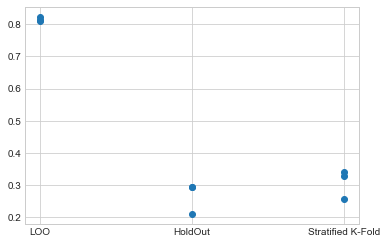

In [104]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 42,stratify=default_groups)
    holdout = compute_KNN_with_Regressor(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
    loo = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(feature)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(feature)
    results.append(holdout)
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(trainX_data,default_groups)
    skfold = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited)  
    skfold.append('Stratified K-Fold')
    skfold.append(feature)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

In [106]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
            result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups)
            result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=preprocess,cross_validation = splited)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 42,stratify=default_groups)
            result = compute_KNN_with_Regressor(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,preprocessing,preprocessingFunc,type
9,0.206065,0.140259,0.374512,0.374530,-0.1,0.0,0.0,0.6,-2.0,2.0,0.892260,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Both
10,0.209271,0.142535,0.377539,0.377569,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890511,MaxAbsScaler,MaxAbsScaler(copy=True),Both
11,0.209324,0.142621,0.377652,0.377686,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890446,None,None,Both
8,0.209431,0.142696,0.377751,0.377784,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890388,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Both
0,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
1,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
2,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only
3,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,None,None,RSSI Only
4,0.295244,0.197304,0.444189,0.443880,-0.2,0.0,0.1,0.8,-1.9,2.0,0.848440,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
5,0.295298,0.197368,0.444262,0.443959,-0.2,0.0,0.1,0.8,-1.9,2.0,0.848391,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI


Selected Preprocessing:  MinMaxScaler


#### Experiment -  Running the KNN function with the different weights

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,weights,type
4,0.209431,0.142696,0.377751,0.377784,-1.000000e-01,0.0,0.0,0.600000,-2.0,2.0,0.890388,uniform,Both
5,0.217703,0.167792,0.409624,0.409658,-4.440892e-16,0.0,0.0,0.748529,-2.0,2.0,0.871111,distance,Both
0,0.294283,0.229321,0.478875,0.478323,-1.000000e-01,0.0,0.1,0.700000,-2.0,1.4,0.823846,uniform,RSSI Only
1,0.294283,0.229321,0.478875,0.478323,-1.000000e-01,0.0,0.1,0.700000,-2.0,1.4,0.823846,distance,RSSI Only
2,0.295244,0.197304,0.444189,0.443880,-2.000000e-01,0.0,0.1,0.800000,-1.9,2.0,0.848440,uniform,Rolling Mean RSSI
3,0.311892,0.231991,0.481655,0.481209,-1.935501e-01,0.0,0.1,0.833333,-2.0,2.0,0.821795,distance,Rolling Mean RSSI


Selected weight:  uniform


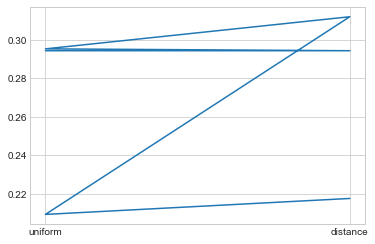

In [111]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','weights','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for weight in weights:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
            result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited,
                                               weights=weight)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups)
            result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited,
                                               weights=weight)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 42,stratify=default_groups)
            result = compute_KNN_with_Regressor(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                scaler=StandardScaler(),weights=weight)
        result.append(weight)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

#### Experiment - Running the KNN function with the different algorithms

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,algorithm,type
8,0.209003,0.139046,0.372889,0.372937,-0.1,0.0,0.0,0.6,-2.0,2.0,0.893191,brute,Both
9,0.209431,0.142696,0.377751,0.377784,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890388,kd_tree,Both
11,0.209431,0.142696,0.377751,0.377784,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890388,auto,Both
10,0.209618,0.143190,0.378404,0.378445,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890008,ball_tree,Both
4,0.290329,0.199949,0.447157,0.447057,-0.2,0.0,0.1,0.8,-1.9,2.0,0.846409,brute,Rolling Mean RSSI
0,0.291023,0.218084,0.466995,0.463021,-0.2,0.0,0.1,0.6,-1.9,1.1,0.832478,brute,RSSI Only
1,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,kd_tree,RSSI Only
2,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,ball_tree,RSSI Only
3,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,auto,RSSI Only
6,0.295111,0.197136,0.444000,0.443676,-0.2,0.0,0.1,0.8,-1.9,2.0,0.848570,ball_tree,Rolling Mean RSSI


Selected algorithm:  brute


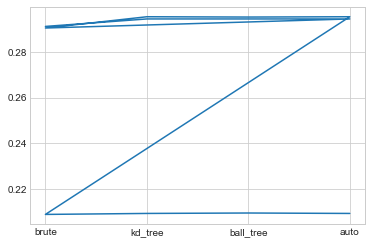

In [112]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','algorithm','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for algorithm in algorithms:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
            result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited,
                                               algorithm=algorithm)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups)
            result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited,
                                               algorithm=algorithm)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 42,stratify=default_groups)
            result = compute_KNN_with_Regressor(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                scaler=StandardScaler(),algorithm=algorithm)
        result.append(algorithm)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['algorithm'],statistics['mae'])
selected_algorithm = statistics.sort_values(by=['mae'])['algorithm'].head(1).values[0]
print("Selected algorithm: ",selected_algorithm)

#### Experiment - Running the KNN function with the different distance metrics

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,distance,type
9,0.209351,0.142688,0.377740,0.377768,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890394,manhattan,Both
11,0.209378,0.142738,0.377807,0.377836,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890355,braycurtis,Both
8,0.209431,0.142696,0.377751,0.377784,-0.1,0.0,0.0,0.6,-2.0,2.0,0.890388,euclidean,Both
10,0.209885,0.143297,0.378546,0.378580,-0.1,0.0,0.0,0.6,-2.0,2.0,0.889926,canberra,Both
0,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,euclidean,RSSI Only
1,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,manhattan,RSSI Only
2,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,canberra,RSSI Only
3,0.294283,0.229321,0.478875,0.478323,-0.1,0.0,0.1,0.7,-2.0,1.4,0.823846,braycurtis,RSSI Only
4,0.295244,0.197304,0.444189,0.443880,-0.2,0.0,0.1,0.8,-1.9,2.0,0.848440,euclidean,Rolling Mean RSSI
5,0.295244,0.197304,0.444189,0.443880,-0.2,0.0,0.1,0.8,-1.9,2.0,0.848440,manhattan,Rolling Mean RSSI


Selected distance:  manhattan


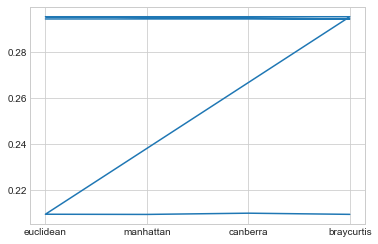

In [113]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','distance','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for distance in distance_metris:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
            result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited,
                                               metric=distance)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups)
            result = compute_KNN_with_Regressor(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited,
                                               metric=distance)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 42,stratify=default_groups)
            result = compute_KNN_with_Regressor(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                scaler=StandardScaler(),metric=distance)
        result.append(distance)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['distance'],statistics['mae'])
selected_distance = statistics.sort_values(by=['mae'])['distance'].head(1).values[0]
print("Selected distance: ",selected_distance)

#### Experiment - Tuning the K parameter

{'knn__n_neighbors': 2}
Max accuracy:  -8.222995598634867
{'knn__n_neighbors': 27}
Max accuracy:  -7.093488100016766
{'knn__n_neighbors': 16}
Max accuracy:  -6.772070672708102


,n_neighbhors,type
0,2,RSSI Only
1,27,Rolling Mean RSSI
2,16,Both


Text(0, 0.5, 'Cross-validated accuracy')

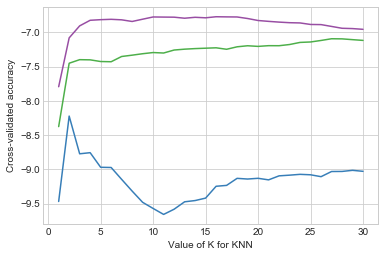

In [114]:
statistical_cols = ['n_neighbhors','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
num = 0
palette = plt.get_cmap('Set1')
grid_results = list()
k_range = list(range(1, 31))
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    result = list()
    knn_regressor_estimator = KNeighborsRegressor() #init knn regressor estimator
    param_grid = {'knn__n_neighbors': k_range}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_regressor_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=selected_fold)
    #fit model to data
    estimator.fit(trainX_data,train_Y)
    print(estimator.best_params_)
    grid_mean_scores = estimator.cv_results_['mean_test_score']
    print('Max accuracy: ', max(grid_mean_scores))
    grid_result = [grid_mean_scores]
    result.append(estimator.best_params_['knn__n_neighbors'])
    result.append(feature)
    results.append(result)
    grid_results.append(grid_result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
for grid in grid_results:
    num+=1
    plt.plot(k_range, grid[0],color=palette(num))
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

### Run GridSearch for parameter tunning

In [117]:
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
num = 0
palette = plt.get_cmap('Set1')
grid_results = list()
k_range = list(range(1, 31))
tuned_parameters = {
    'knn__n_neighbors': k_range,
    'knn__metric':distance_metris,
    'knn__weights':weights,
    'knn__algorithm':algorithms
}
scores = ['r2']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    for feature in types:
        #Decide on type of data
        if feature == 'RSSI Only':
            trainX_data = train_X_rssi
        elif feature == 'Rolling Mean RSSI':
            trainX_data = train_X_rolling_mean
        else:
            trainX_data = combination_features_X 
        pipe = Pipeline([('standardizer', StandardScaler()), ('knn', KNeighborsRegressor())])
        clf = RandomizedSearchCV(pipe, tuned_parameters,n_iter=75,cv=StratifiedKFold(n_splits=selected_fold, shuffle=True, random_state=42).split(trainX_data, default_groups),scoring=score,n_jobs=-1,verbose=1
        )
        clf.fit(trainX_data,train_Y)
        clf.best_params_['score'] = score
        clf.best_params_['best_score'] = clf.best_score_
        clf.best_params_['type'] = feature
        results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results).sort_values(by=['best_score'],ascending=False)
display(gridcv_results)

# Tuning hyper-parameters for r2

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   29.4s finished


,knn__weights,knn__n_neighbors,knn__metric,knn__algorithm,score,best_score,type
2,uniform,21,braycurtis,ball_tree,r2,0.903760,Both
1,uniform,29,braycurtis,brute,r2,0.870036,Rolling Mean RSSI
0,distance,29,canberra,brute,r2,0.817095,RSSI Only


### Best Parameters
Display the best parameters tunned throughout the experiments

In [118]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance']
conclusion_list = [21,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,K Parameter,Cross Validation,Weight,Preprocessing,Algorithm,Distance
0,21,HoldOut,uniform,MinMaxScaler,brute,manhattan


### Best Results
Compute KNN with the best parameters in both RSSI and Rolling Mean

In [120]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
        result = compute_KNN_with_Regressor(n_neighbors=12,testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited,
                            algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(trainX_data,default_groups)
        result = compute_KNN_with_Regressor(n_neighbors=12,testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),
                                             cross_validation = splited,
                            algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 42,stratify=default_groups)
        result = compute_KNN_with_Regressor(n_neighbors=12,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
2,0.205094,0.127218,0.356676,0.356715,-0.083333,0.0,0.000,0.625000,-1.875000,1.791667,0.902277,Both
1,0.281370,0.178057,0.421968,0.421884,-0.166667,0.0,0.125,0.708333,-1.708333,1.708333,0.863225,Rolling Mean RSSI
0,0.291711,0.207328,0.455333,0.455352,-0.083333,0.0,0.125,0.750000,-1.625000,1.166667,0.840741,RSSI Only


### Best Results - Testing data (using data recovered from Android 6.0 Asus ZENFONE Live)
Experiment with testing dataset

,Actual,Predicted
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.000000
...,...,...
410,3.5,3.476190
411,3.5,2.833333
412,3.5,2.833333
413,3.5,2.547619


,Actual,Predicted
0,0.0,2.9
1,0.0,2.9
2,0.0,2.9
3,0.0,2.9
4,0.0,2.9
...,...,...
410,3.5,2.9
411,3.5,2.9
412,3.5,2.9
413,3.5,2.9


,Actual,Predicted
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.000000
...,...,...
410,3.5,3.142857
411,3.5,3.214286
412,3.5,3.190476
413,3.5,3.261905


,Actual,Predicted
0,0.0,3.0
1,0.0,3.0
2,0.0,3.0
3,0.0,3.0
4,0.0,3.0
...,...,...
410,3.5,3.0
411,3.5,3.0
412,3.5,3.0
413,3.5,3.0


,Actual,Predicted
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.000000
...,...,...
410,3.5,3.309524
411,3.5,2.952381
412,3.5,3.238095
413,3.5,2.976190


,Actual,Predicted
0,0.0,2.9
1,0.0,2.9
2,0.0,2.9
3,0.0,2.9
4,0.0,2.9
...,...,...
410,3.5,2.9
411,3.5,2.9
412,3.5,2.9
413,3.5,2.9


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type,Tuning
2,0.632989,0.664739,0.815315,0.722892,-0.071429,0.452381,0.661905,1.807143,-1.500000,2.285714,0.486700,Rolling Mean RSSI,True
0,0.705565,0.748704,0.865277,0.809939,-0.333333,0.452381,0.585714,1.547619,-1.500000,2.476190,0.421864,RSSI Only,True
4,0.709466,0.808849,0.899360,0.787031,-0.095238,0.476190,0.800000,1.840476,-1.428571,2.452381,0.375421,Both,True
1,1.325060,2.618916,1.618306,1.139367,0.400000,1.400000,1.900000,2.900000,-0.600000,2.900000,-1.022282,RSSI Only,False
5,1.325060,2.618916,1.618306,1.139367,0.400000,1.400000,1.900000,2.900000,-0.600000,2.900000,-1.022282,Both,False
3,1.375904,2.859036,1.690868,1.139367,0.500000,1.500000,2.000000,3.000000,-0.500000,3.000000,-1.207699,Rolling Mean RSSI,False


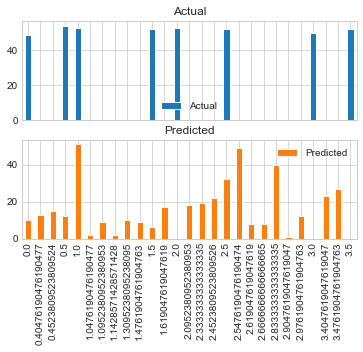

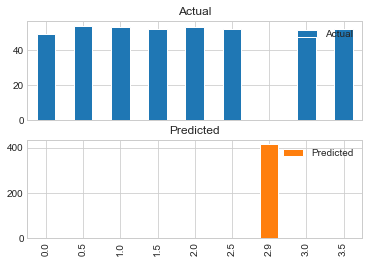

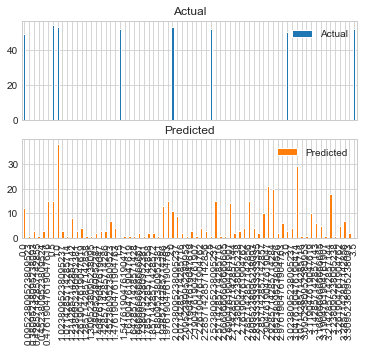

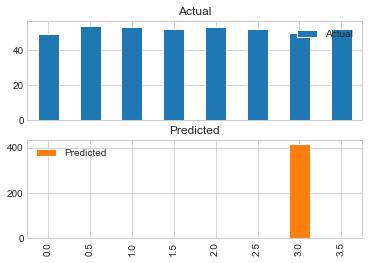

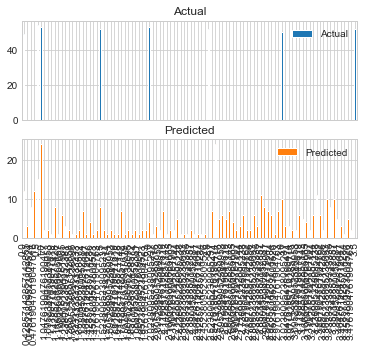

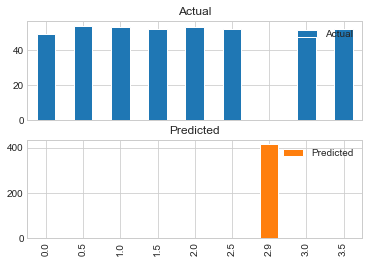

In [123]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X 
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = KNeighborsRegressor(n_neighbors=21,algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
        else: 
            model = KNeighborsRegressor()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y)
        predict_test = model.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(test_Y,predict_test)
        statistical_array = list()
        error_dataframe = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted':predict_test.flatten()})
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
        error = pd.DataFrame(observed_errors, columns=["error"])
        result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
        data = structure_data(result,coefficient_determination)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

### Best Results - Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71)
Experiment with testing dataset

,Actual,Predicted
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.000000
...,...,...
2279,3.5,2.833333
2280,3.5,3.404762
2281,3.5,3.404762
2282,3.5,2.714286


,Actual,Predicted
0,0.0,2.9
1,0.0,2.9
2,0.0,2.9
3,0.0,2.9
4,0.0,2.9
...,...,...
2279,3.5,2.9
2280,3.5,2.9
2281,3.5,2.9
2282,3.5,2.9


,Actual,Predicted
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.000000
...,...,...
2279,3.5,3.023810
2280,3.5,3.047619
2281,3.5,3.071429
2282,3.5,3.190476


,Actual,Predicted
0,0.0,3.0
1,0.0,3.0
2,0.0,3.0
3,0.0,3.0
4,0.0,3.0
...,...,...
2279,3.5,3.0
2280,3.5,3.0
2281,3.5,3.0
2282,3.5,3.0


,Actual,Predicted
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.000000
...,...,...
2279,3.5,2.904762
2280,3.5,3.452381
2281,3.5,3.452381
2282,3.5,2.690476


,Actual,Predicted
0,0.0,2.9
1,0.0,2.9
2,0.0,2.9
3,0.0,2.9
4,0.0,2.9
...,...,...
2279,3.5,2.9
2280,3.5,2.9
2281,3.5,2.9
2282,3.5,2.9


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type,Tuning
2,0.598980,0.723919,0.850834,0.845979,-0.452381,0.0,0.119048,1.880952,-2.000000,2.547619,0.446120,Rolling Mean RSSI,True
4,0.605193,0.753619,0.868112,0.860505,-0.428571,0.0,0.169048,1.925000,-1.857143,2.880952,0.423397,Both,True
0,0.618036,0.725738,0.851902,0.850778,-0.666667,0.0,0.000000,1.642857,-2.000000,2.904762,0.444729,RSSI Only,True
1,1.326751,2.642115,1.625458,1.143490,0.400000,1.4,1.900000,2.900000,-0.600000,2.900000,-1.021515,RSSI Only,False
5,1.326751,2.642115,1.625458,1.143490,0.400000,1.4,1.900000,2.900000,-0.600000,2.900000,-1.021515,Both,False
3,1.377189,2.883209,1.698002,1.143490,0.500000,1.5,2.000000,3.000000,-0.500000,3.000000,-1.205980,Rolling Mean RSSI,False


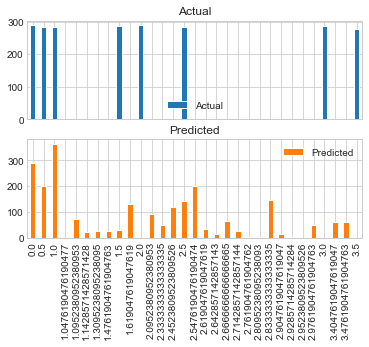

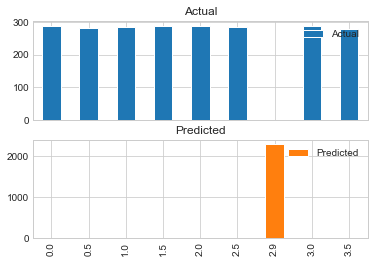

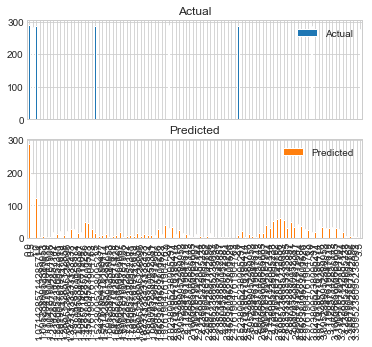

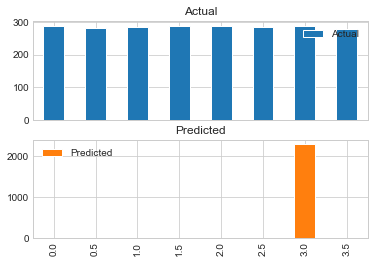

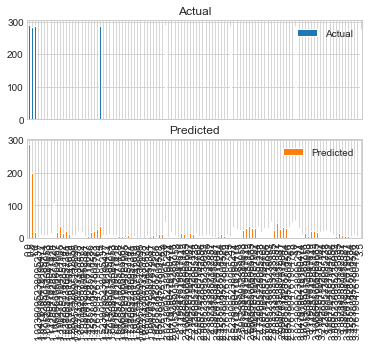

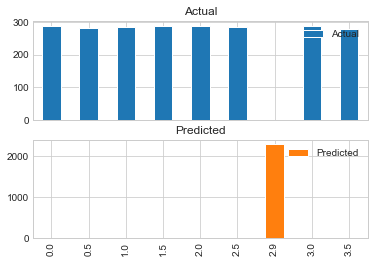

In [ ]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_my_device
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_my_device
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_my_device
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = KNeighborsRegressor(n_neighbors=21,algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
        else: 
            model = KNeighborsRegressor()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y)
        predict_test = model.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(test_Y_my_device,predict_test)
        statistical_array = list()
        error_dataframe = pd.DataFrame({'Actual': test_Y_my_device.flatten(), 'Predicted':predict_test.flatten()})
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
        error = pd.DataFrame(observed_errors, columns=["error"])
        result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
        data = structure_data(result,coefficient_determination)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))